In [1]:
# PROJECT/IMPLEMENTATION IDEAS
# 1. Historical market cap, % bitcoin (requires crawling https://coinmarketcap.com/historical/)
# 2. Twitter sentiment analysis of Bitcoin vs price
# 3. Bitcoin vs. altcoin market caps
# 4. Transaction fees, user/address count(?), other features(?) vs bitcoin price
# 5. Usage by country
# 6. Bitcoin trading by exchange
# 7. Bitcoin trading by currency
# 8. Increase in leverage?

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from pandas.core import datetools
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import dateutil.parser
from pprint import pprint
import json
import time
import sys
import re
import datetime

# APIs
# import quandl
# import coinmarketcap

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Helper functions
def to_currency(int):
    return "${:,.0f}".format(int//1000000)

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

def list_to_average(list):
    try:
        avg = list[0]/list[1]
    except:
        avg = 0
    return avg

# def none_to_value(num):
#     if num == None:
#         num = 


In [4]:
df = pd.read_pickle('data/benson_btcsentiment_df.pkl')
df = df[['BTCPrice','ETHPrice','BTCVol','TxFees','CostperTxn','NoTxns','AvgBlkSz','UniqueAddresses','HashRate','Crypto Market Cap','Nasdaq','Gold','Interest']]
df_all = df
df_hist = df
df.head()

,BTCPrice,ETHPrice,BTCVol,TxFees,CostperTxn,NoTxns,AvgBlkSz,UniqueAddresses,HashRate,Crypto Market Cap,Nasdaq,Gold,Interest
Date,,,,,,,,,,,,,
2016-07-13,656.669626,10.55,871225.091442,34693.70,5.69,219034.0,0.77,379937.0,1516960.89,1.225459e+10,5005.73,227.19,3.0
2016-07-14,656.132060,10.49,872834.409470,35233.50,5.06,218093.0,0.81,367252.0,1379055.35,1.225459e+10,5034.06,226.88,3.0
2016-07-15,663.841255,11.50,756558.628070,38613.99,5.49,220655.0,0.79,367953.0,1506352.77,1.225459e+10,5029.59,224.00,3.0
2016-07-17,663.841255,11.50,756558.628070,38613.99,5.49,220655.0,0.79,367953.0,1506352.77,1.288271e+10,5029.59,224.00,3.0
2016-07-18,680.149570,11.35,752528.346010,32557.41,7.59,171013.0,0.70,330330.0,1580609.59,1.288271e+10,5055.78,224.43,3.0


In [5]:
df_all.corr().sort_values('BTCPrice')

,BTCPrice,ETHPrice,BTCVol,TxFees,CostperTxn,NoTxns,AvgBlkSz,UniqueAddresses,HashRate,Crypto Market Cap,Nasdaq,Gold,Interest
BTCVol,-0.225470,-0.272558,1.000000,-0.158796,-0.237707,0.023268,-0.142350,-0.150224,-0.296365,-0.216190,-0.403532,-0.225064,-0.195406
Gold,-0.187556,-0.150817,-0.225064,-0.117919,-0.156500,-0.379828,-0.383665,-0.382505,-0.227259,-0.126234,-0.358456,1.000000,-0.209334
NoTxns,0.514470,0.333694,0.023268,0.461859,0.373222,1.000000,0.636758,0.868469,0.432321,0.395422,0.420018,-0.379828,0.555360
AvgBlkSz,0.561498,0.526360,-0.142350,0.486435,0.511380,0.636758,1.000000,0.690483,0.542406,0.524244,0.627293,-0.383665,0.539770
Nasdaq,0.810363,0.853506,-0.403532,0.630463,0.822671,0.420018,0.627293,0.733861,0.922513,0.795697,1.000000,-0.358456,0.742816
UniqueAddresses,0.817754,0.683733,-0.150224,0.733242,0.712456,0.868469,0.690483,1.000000,0.748732,0.721769,0.733861,-0.382505,0.809705
TxFees,0.877973,0.810344,-0.158796,1.000000,0.887515,0.461859,0.486435,0.733242,0.734283,0.875711,0.630463,-0.117919,0.803368
ETHPrice,0.889573,1.000000,-0.272558,0.810344,0.934816,0.333694,0.526360,0.683733,0.931258,0.969573,0.853506,-0.150817,0.778019
HashRate,0.910647,0.931258,-0.296365,0.734283,0.928906,0.432321,0.542406,0.748732,1.000000,0.916777,0.922513,-0.227259,0.817456
Crypto Market Cap,0.928289,0.969573,-0.216190,0.875711,0.955806,0.395422,0.524244,0.721769,0.916777,1.000000,0.795697,-0.126234,0.823137


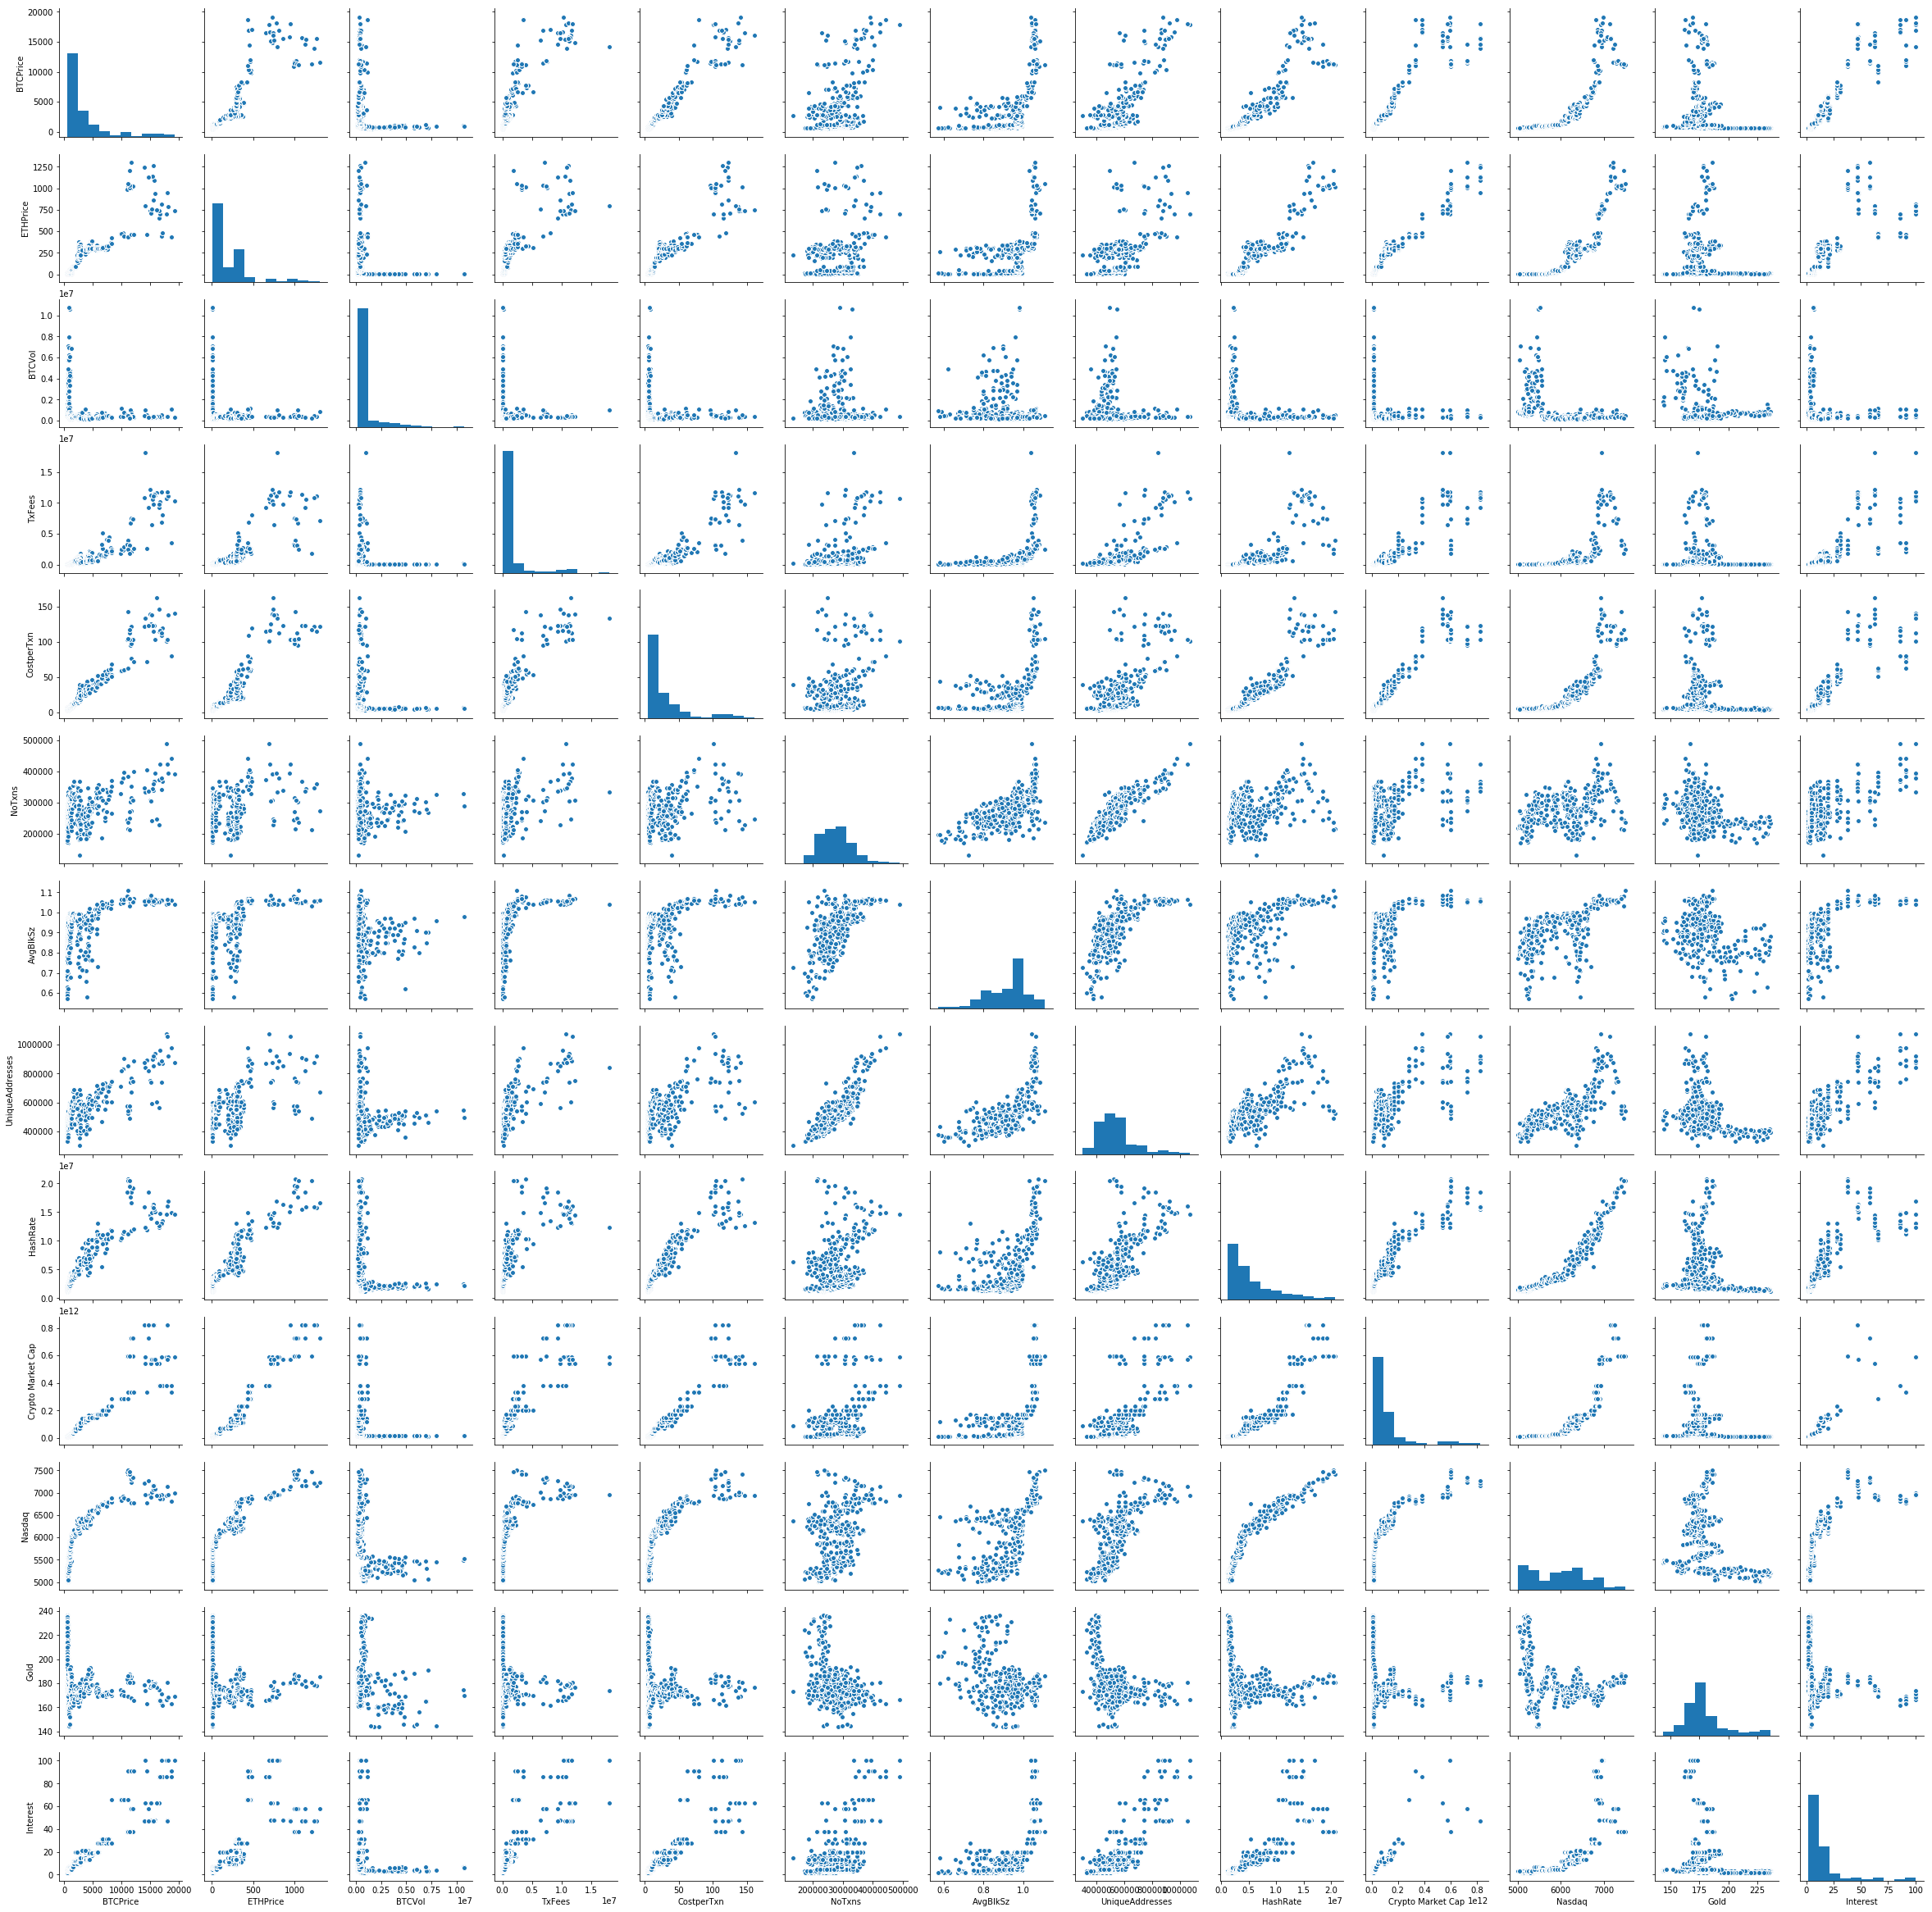

In [6]:
sns.pairplot(df_all)

In [7]:
# Reducing to few key features
df_all = df_all[['BTCPrice','TxFees','Nasdaq','Interest']]
df_all.corr().sort_values('BTCPrice')

,BTCPrice,TxFees,Nasdaq,Interest
Nasdaq,0.810363,0.630463,1.000000,0.742816
TxFees,0.877973,1.000000,0.630463,0.803368
Interest,0.938834,0.803368,0.742816,1.000000
BTCPrice,1.000000,0.877973,0.810363,0.938834


'\nPossible leading indicators:\nGoogle Search Interest\n\n\nFollowing Indicators:\nCost per Transaction\nCrypto Market Cap\nEthereum Price\n'

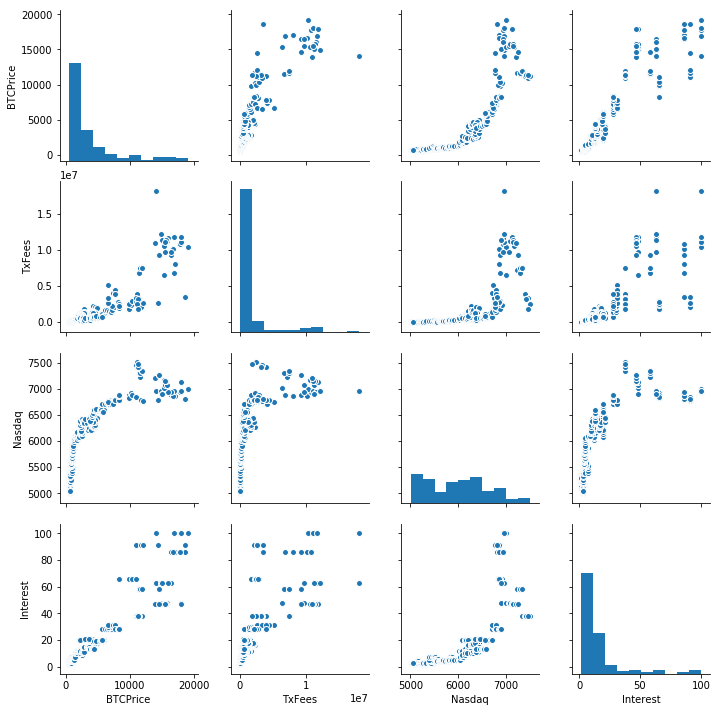

In [8]:
sns.pairplot(df_all)
'''
Possible leading indicators:
Google Search Interest


Following Indicators:
Cost per Transaction
Crypto Market Cap
Ethereum Price
'''

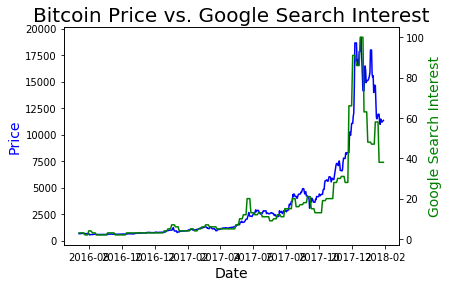

None


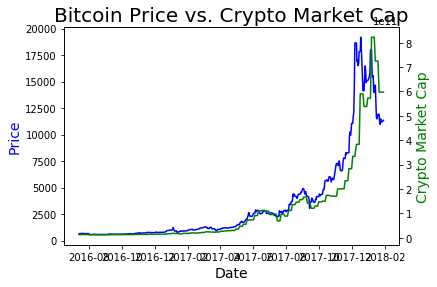

None


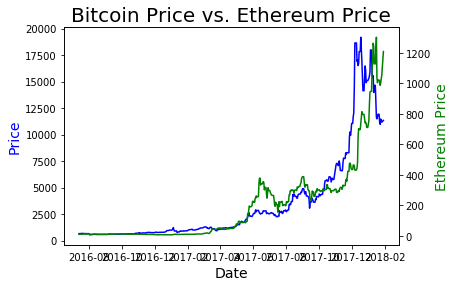

None


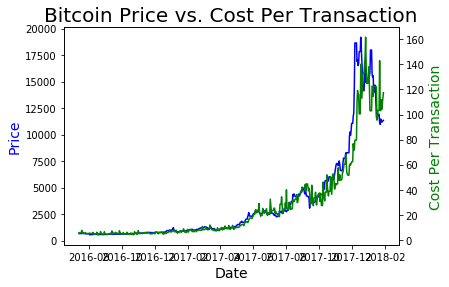

None


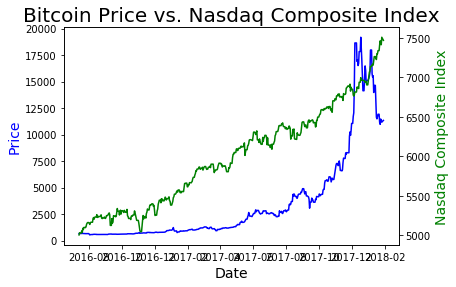

None


In [9]:
# BTC Price vs Google Search Interest
df_all = df
y1 = pd.Series(df_all['BTCPrice'])
y2 = pd.Series(df_all['Interest'])
x = pd.Series(df_all.index.values)

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("Google Search Interest",fontsize=14,color='green')
# ax.grid(True)
plt.title("Bitcoin Price vs. Google Search Interest", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
# plt.tight_layout()
plt.savefig('charts/googlesearchinterest.png')
print(plt.show())

# BTC Price vs Crypto Market Cap
y2 = pd.Series(df_all['Crypto Market Cap'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("Crypto Market Cap",fontsize=14,color='green')
# ax.grid(True)
plt.title("Bitcoin Price vs. Crypto Market Cap", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
# plt.tight_layout()
plt.savefig('charts/cryptomarketcap.png')
print(plt.show())

# BTC Price vs ETH Price
y2 = pd.Series(df_all['ETHPrice'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("Ethereum Price",fontsize=14,color='green')
# ax.grid(True)
plt.title("Bitcoin Price vs. Ethereum Price", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
# plt.tight_layout()
plt.savefig('charts/ethprice.png')
print(plt.show())

# BTC Price vs ETH Price
y2 = pd.Series(df_all['CostperTxn'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("Cost Per Transaction",fontsize=14,color='green')
# ax.grid(True)
plt.title("Bitcoin Price vs. Cost Per Transaction", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
# plt.tight_layout()
plt.savefig('charts/costpertxn.png')
print(plt.show())

# BTC Price vs Nasdaq
y2 = pd.Series(df_all['Nasdaq'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("Nasdaq Composite Index",fontsize=14,color='green')
# ax.grid(True)
plt.title("Bitcoin Price vs. Nasdaq Composite Index", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
# plt.tight_layout()
plt.savefig('charts/nasdaq.png')
print(plt.show())

In [10]:
df = df_all
# STATSMODELS
# Create your feature matrix (X) and target vector (y)
df_stats = df[['BTCPrice','Interest','Nasdaq','HashRate']]
y, X = patsy.dmatrices('BTCPrice ~ Interest + Nasdaq + HashRate', data=df, return_type="dataframe")

# Create your model
model = sm.OLS(y,X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               BTCPrice   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     2723.
Date:                Tue, 30 Jan 2018   Prob (F-statistic):          6.54e-292
Time:                        17:10:55   Log-Likelihood:                -3844.7
No. Observations:                 463   AIC:                             7697.
Df Residuals:                     459   BIC:                             7714.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4796.8217   1007.072      4.763      0.000    2817.778    6775.865
Interest     123.3814      3.976     31.030      0.000     115.568     131.195
Nasdaq        -1.0640      0.191     -5.566      0.000      -1.440      -0.688
HashRate       0.0006   3.18e-05     17.846      0.000       0.001       0.001
==============================================================================
Omnibus:                      160.830   Durbin-Watson:                   0.509
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1934.298
Skew:                           1.136   Prob(JB):                         0.00
Kurtosis:                      12.752   Cond. No.                     1.54e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.54e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
# SKLEARN
# Create an empty model
lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = df.iloc[:,2:]
# Choose the response variable(s)
y = df.iloc[:,1]
# Fit the model to the full dataset
lr.fit(X,y)
# Print out the R^2 for the model against the full dataset
print(lr.score(X,y))

0.9672781824352372


In [12]:
df.columns

Index(['BTCPrice', 'ETHPrice', 'BTCVol', 'TxFees', 'CostperTxn', 'NoTxns',
       'AvgBlkSz', 'UniqueAddresses', 'HashRate', 'Crypto Market Cap',
       'Nasdaq', 'Gold', 'Interest'],
      dtype='object')

In [13]:
# Create an empty model
lr1 = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X3 + X6 model
X = df[['BTCPrice','Interest','Nasdaq','HashRate']]
# Choose the response variable(s)
y = df['BTCPrice']
# Fit the model to the full dataset
lr1.fit(X,y)
# Print out the R^2 for the model against the full dataset
print(lr1.score(X,y))
print(lr1.intercept_)
print(lr1.coef_)

1.0
2.5011104298755527e-11
[ 1.00000000e+00 -5.03485865e-15  3.47078912e-16 -4.80237591e-18]


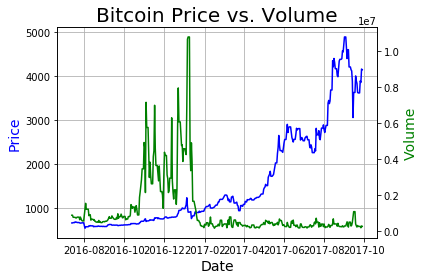

None


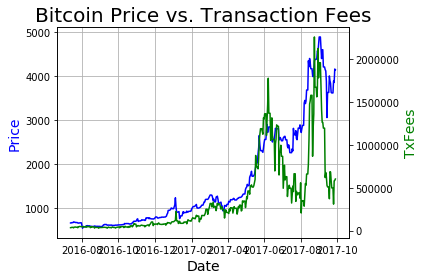

None


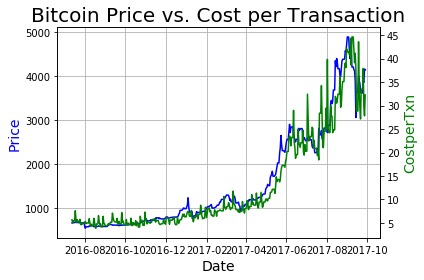

None


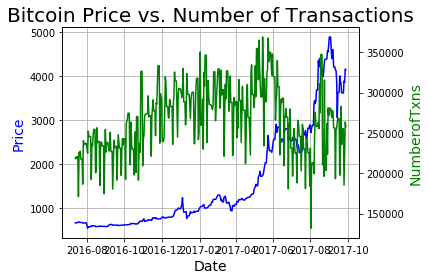

None


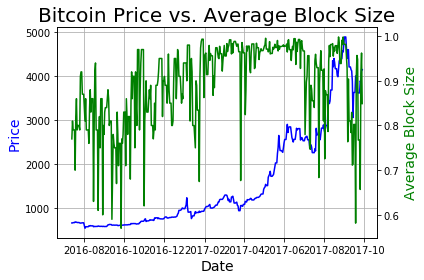

None


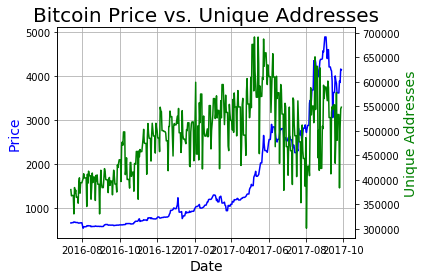

None


In [14]:
# BTC Price vs Volume
df_all = df_all[:365]

y1 = pd.Series(df_all['BTCPrice'])
y2 = pd.Series(df_all['BTCVol'])
x = pd.Series(df_all.index.values)

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("Volume",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Volume", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig1.png')
print(plt.show())

# BTC Price vs Transaction Fees
y2 = pd.Series(df_all['TxFees'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("TxFees",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Transaction Fees", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig2.png')
print(plt.show())

# BTC Price vs Cost per Transaction
y2 = pd.Series(df_all['CostperTxn'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("CostperTxn",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Cost per Transaction", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig3.png')
print(plt.show())

# BTC Price vs Number of Transactions
y2 = pd.Series(df_all['NoTxns'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("NumberofTxns",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Number of Transactions", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig4.png')
print(plt.show())


# BTC Price vs Block Size
y2 = pd.Series(df_all['AvgBlkSz'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("Average Block Size",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Average Block Size", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig6.png')
print(plt.show())

# BTC Price vs Unique Addresses
y2 = pd.Series(df_all['UniqueAddresses'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("Unique Addresses",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Unique Addresses", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig7.png')
print(plt.show())

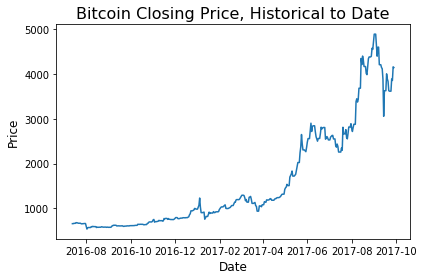

None


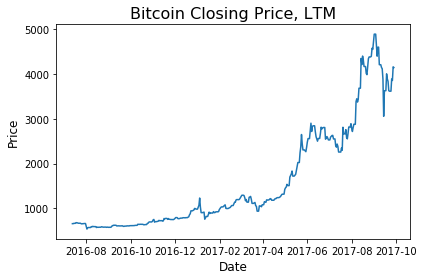

None


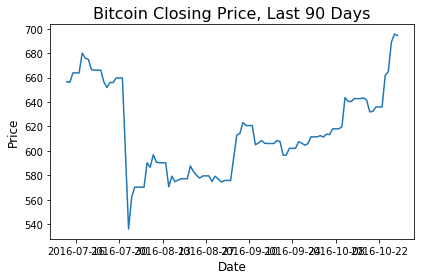

None


In [15]:
# Bitcoin prices, called via Quandl API
# mydata = pd.read_csv('https://www.quandl.com/api/v3/datasets/BNC3/GWA_BTC.csv?api_key=pvPBMBW8afR_HqVfio9o')
# mydata['Date']=mydata['Date'].apply(to_date)
df = df_all
y = pd.Series(df['BTCPrice'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Closing Price, Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCPriceQuandl.png')
print(plt.show())

df = df[:365]
y = pd.Series(df['BTCPrice'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Closing Price, LTM",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/LTMBTCPriceQuandl.png')
print(plt.show())

df = df[:90]
y = pd.Series(df['BTCPrice'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Closing Price, Last 90 Days",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/90DBTCPriceQuandl.png')
print(plt.show())

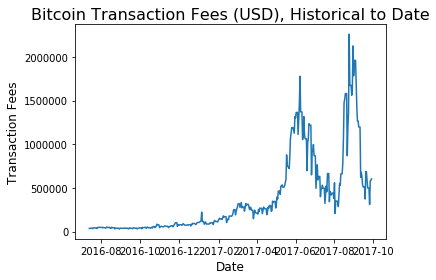

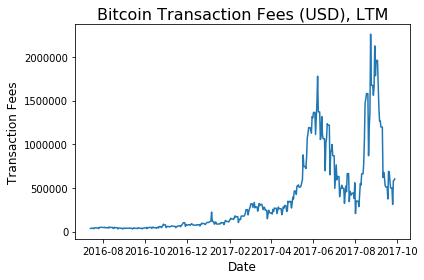

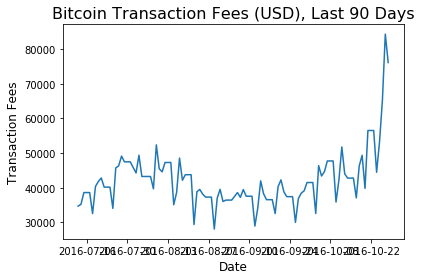

In [16]:
# Quandl: BTC transaction fees USD
# mydata = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/TRFUS.csv?api_key=pvPBMBW8afR_HqVfio9o')
# mydata['Date']=mydata['Date'].apply(to_date)
df = df_all
y = pd.Series(df['TxFees'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Transaction Fees (USD), Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Transaction Fees', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCTxnFeesQuandl.png')
plt.show()

df = df[:365]
y = pd.Series(df['TxFees'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Transaction Fees (USD), LTM",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Transaction Fees', fontsize=12)
plt.tight_layout()
plt.savefig('charts/LTMBTCTxnFeesQuandl.png')
plt.show()

df = df[:90]
y = pd.Series(df['TxFees'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Transaction Fees (USD), Last 90 Days",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Transaction Fees', fontsize=12)
plt.tight_layout()
plt.savefig('charts/90DBTCTxnFeesQuandl.png')
plt.show()

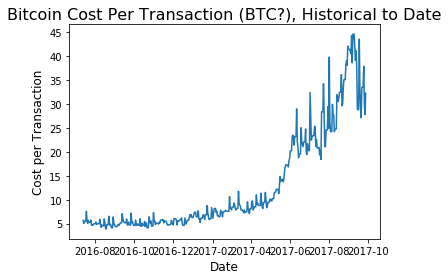

In [17]:
# Quandl: BTC Cost Per Transaction BTC(?)
# mydata = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/CPTRA.csv?api_key=pvPBMBW8afR_HqVfio9o')
# mydata['Date']=mydata['Date'].apply(to_date)
df = df_all
y = pd.Series(df['CostperTxn'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Cost Per Transaction (BTC?), Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cost per Transaction', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCCostperTxnQuandl.png')
plt.show()

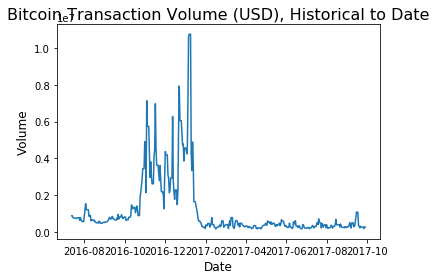

In [18]:
# Quandl: BTC transaction volume USD
# mydata = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/ETRVU.csv?api_key=pvPBMBW8afR_HqVfio9o')
df = df_all
y = pd.Series(df['BTCVol'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Transaction Volume (USD), Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCTxnVolQuandl.png')
plt.show()

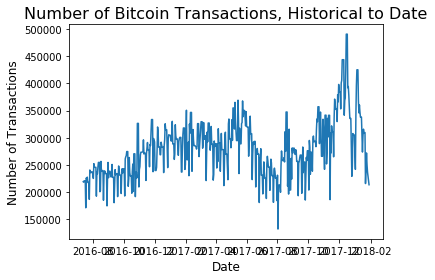

In [19]:
# Quandl: # BTC Transactions
# mydata = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/NTRAN.csv?api_key=pvPBMBW8afR_HqVfio9o')
df = df_hist
y = pd.Series(df['NoTxns'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Number of Bitcoin Transactions, Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCTxnAmtQuandl.png')
plt.show()

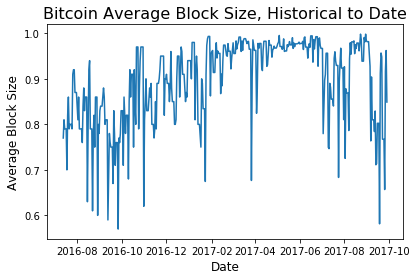

In [20]:
# Quandl: BTC Average Block Size
# mydata = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/AVBLS.csv?api_key=pvPBMBW8afR_HqVfio9o')
df = df_all
y = pd.Series(df['AvgBlkSz'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Average Block Size, Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Block Size', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCAvgBlockSizeQuandl.png')
plt.show()

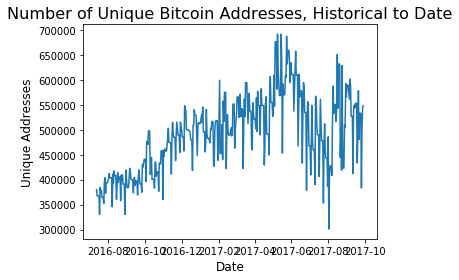

In [21]:
# Quandl: Unique BTC Addresses
# mydata = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/NADDU.csv?api_key=pvPBMBW8afR_HqVfio9o')
df = df_all
y = pd.Series(df['UniqueAddresses'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Number of Unique Bitcoin Addresses, Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Unique Addresses', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCNoAddressesQuandl.png')
plt.show()

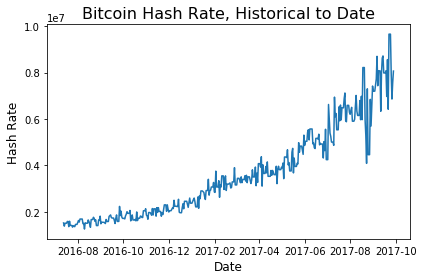

In [22]:
# Quandl: BTC Hash Rate
df = df_all
y = pd.Series(df['HashRate'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Hash Rate, Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Hash Rate', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCHashRateQuandl.png')
plt.show()

In [23]:
# Coinmarketcap: Current
url = 'https://coinmarketcap.com/all/views/all/'
response=requests.get(url)
page=response.text
soup=BeautifulSoup(page,"lxml")

tables=soup.find_all("table")

rows=[row for row in tables[0].find_all('tr')]
df = pd.read_html(tables[0].prettify())[0]
df.head()

,#,Name,Symbol,Market Cap,Price,Circulating Supply,Volume (24h),% 1h,% 24h,% 7d
0,1,BTC Bitcoin,BTC,"$164,615,331,911",$9777.42,16836275,"$8,697,790,000",-3.27%,-12.87%,-10.47%
1,2,ETH Ethereum,ETH,"$100,670,800,781",$1034.50,97313486,"$4,136,870,000",-3.43%,-11.87%,4.79%
2,3,XRP Ripple,XRP,"$40,433,592,918",$1.04,"38,739,142,811 *","$1,188,220,000",-7.58%,-20.11%,-22.66%
3,4,BCH Bitcoin Cash,BCH,"$23,823,298,828",$1406.25,16941013,"$655,765,000",-4.24%,-14.62%,-13.28%
4,5,ADA Cardano,ADA,"$12,220,387,646",$0.471337,"25,927,070,538 *","$371,062,000",-9.70%,-23.05%,-16.24%


In [24]:
btcsa = pd.read_json('btcpricesentiment_mc7.json',convert_axes=False).T # connect to most recent active file

btcsa['Date'] = btcsa.index
btcsa['Date'] = pd.to_datetime(btcsa['Date'])
btcsa['Bitcoin_S'] = btcsa['bitcoin_S'].apply(list_to_average)
btcsa['Ethereum_S'] = btcsa['ethereum_S'].apply(list_to_average)
btcsa['Blockchain_S'] = btcsa['blockchain_S'].apply(list_to_average)
btcsa = btcsa[['Date','Bitcoin_S','Ethereum_S','Blockchain_S','BTC','ETH','LTC','ADA','EOS','Crypto Market Cap']]
btcsa = btcsa.sort_values('Date')
print(btcsa.shape)
btcsa.head(2)


(286, 10)


,Date,Bitcoin_S,Ethereum_S,Blockchain_S,BTC,ETH,LTC,ADA,EOS,Crypto Market Cap
201801281813,2018-01-28 18:13:00,0.218750,-0.173106,0.437179,"$193,540,756,417","$116,129,045,529","$10,144,386,235","$16,631,593,500","$9,254,599,532","$576,359,759,424"
201801281814,2018-01-28 18:14:00,0.472064,0.472606,0.395227,"$193,540,756,417","$116,129,045,529","$10,144,386,235","$16,631,593,500","$9,254,599,532","$576,359,759,424"


In [25]:
btcsa.tail(2)

,Date,Bitcoin_S,Ethereum_S,Blockchain_S,BTC,ETH,LTC,ADA,EOS,Crypto Market Cap
201801291751,2018-01-29 17:51:00,0.228389,0.363046,0.315000,"$186,825,100,523","$112,969,846,940","$9,824,029,532","$15,522,485,277","$8,616,379,661","$557,602,123,395"
201801291756,2018-01-29 17:56:00,0.145530,0.229288,0.205985,"$186,825,100,523","$112,969,846,940","$9,824,029,532","$15,522,485,277","$8,616,379,661","$557,602,123,395"


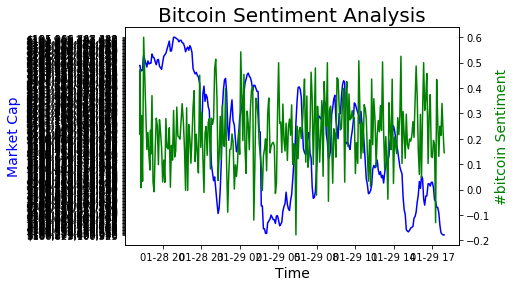

None


In [26]:
btcsa = pd.read_pickle('data/benson_btcsentiment_dfs.pkl')

y1 = pd.Series(btcsa['BTC'])
y2 = pd.Series(btcsa['Bitcoin_S'])
x = pd.Series(btcsa.index.values)

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Market Cap",fontsize=14,color='blue')
ax2.set_ylabel("#bitcoin Sentiment",fontsize=14,color='green')
# ax.grid(True)
plt.title("Bitcoin Sentiment Analysis", fontsize=20,color='black')
ax.set_xlabel('Time', fontsize=14, color='black')
# plt.tight_layout()
plt.savefig('charts/btcsa.png')
print(plt.show())

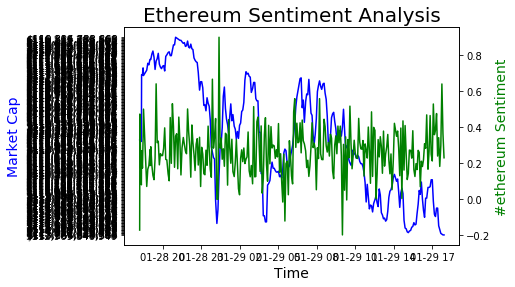

None


In [27]:
y1 = pd.Series(btcsa['ETH'])
y2 = pd.Series(btcsa['Ethereum_S'])
x = pd.Series(btcsa.index.values)

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Market Cap",fontsize=14,color='blue')
ax2.set_ylabel("#ethereum Sentiment",fontsize=14,color='green')
# ax.grid(True)
plt.title("Ethereum Sentiment Analysis", fontsize=20,color='black')
ax.set_xlabel('Time', fontsize=14, color='black')
# plt.tight_layout()
plt.savefig('charts/ethsa.png')
print(plt.show())

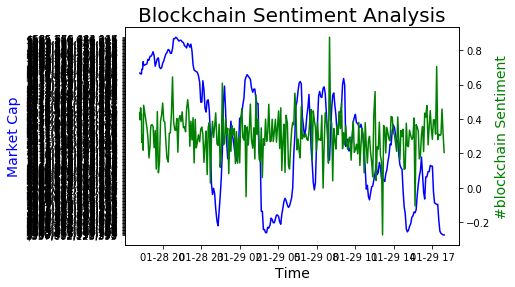

None


In [28]:
y1 = pd.Series(btcsa['Crypto Market Cap'])
y2 = pd.Series(btcsa['Blockchain_S'])
x = pd.Series(btcsa.index.values)

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Market Cap",fontsize=14,color='blue')
ax2.set_ylabel("#blockchain Sentiment",fontsize=14,color='green')
# ax.grid(True)
plt.title("Blockchain Sentiment Analysis", fontsize=20,color='black')
ax.set_xlabel('Time', fontsize=14, color='black')
# plt.tight_layout()
plt.savefig('charts/blksa.png')
print(plt.show())

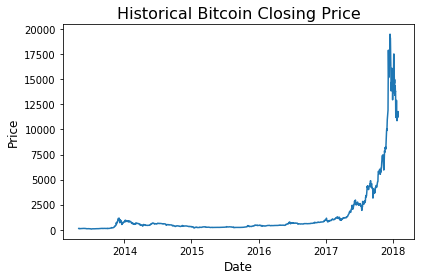

None


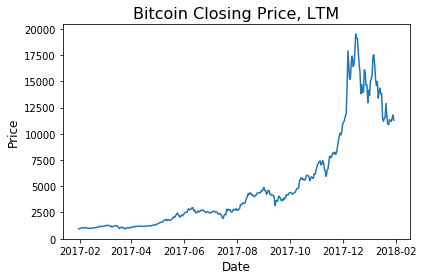

None


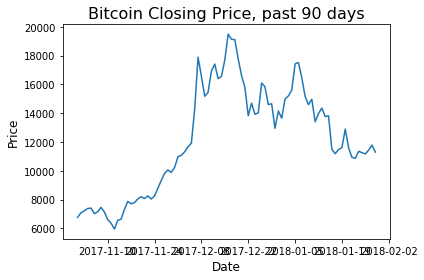

In [29]:
df = pd.read_pickle('data/benson_btcsentiment_dfts.pkl')

y = pd.Series(df['Close'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Historical Bitcoin Closing Price",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistoricalBitcoinPrice.png')
print(plt.show())

# Bitcoin Closing Price, past year
df = df[:365]
y = pd.Series(df['Close'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Closing Price, LTM",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/BitcoinPrice2017.png')
print(plt.show())

# Bitcoin past 90 days
df = df[:90]
y = pd.Series(df['Close'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Closing Price, past 90 days",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/BitcoinPrice2017.png')
plt.show()

In [30]:
# Coinmarketcap scraping: Ethereum
df_eth = pd.read_pickle('data/benson_btcsentiment_dftseth.pkl')
df_eth.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2018-01-29,1246.70,1256.70,1169.08,1182.36,3715080000,121269000000
2018-01-28,1111.78,1257.77,1111.78,1246.01,5372330000,108122000000
2018-01-27,1055.75,1121.98,1042.12,1107.07,3002870000,102651000000
2018-01-26,1052.70,1080.60,996.78,1055.17,3617690000,102334000000
2018-01-25,1063.22,1104.66,1034.74,1056.03,4050190000,103335000000


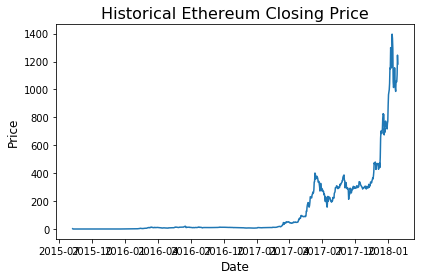

None


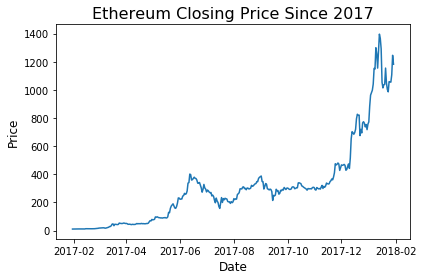

None


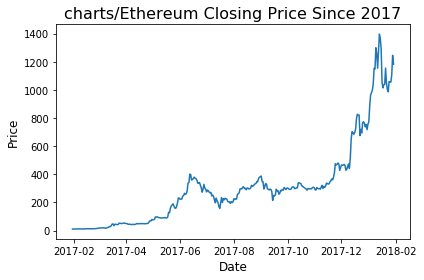

In [31]:
y = pd.Series(df_eth['Close'])
x = pd.Series(df_eth.index.values)

plt.plot(x,y)
plt.title("Historical Ethereum Closing Price",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistoricalEthereumPrice.png')
print(plt.show())

# LTM
df_eth = df_eth[:365]
# print(df.tail())
y = pd.Series(df_eth['Close'])
x = pd.Series(df_eth.index.values)

plt.plot(x,y)
plt.title("Ethereum Closing Price Since 2017",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/EthereumPrice2017.png')
print(plt.show())

# Last 90 days
df_eth = df_eth[:365]
# print(df.tail())
y = pd.Series(df_eth['Close'])
x = pd.Series(df_eth.index.values)

plt.plot(x,y)
plt.title("charts/Ethereum Closing Price Since 2017",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/EthereumPrice2017a.png')
plt.show()

In [32]:
# import pandas
# import json

# from tweepy import Stream
# from tweepy.streaming import StreamListener

# class MyListener(StreamListener):

#     def on_data(self, data):
#         try:
#             with open('bitcoin.json', 'a') as f:
#                 f.write(data)
#                 return True
#         except BaseException as e:
#             print("Error on_data: %s" % str(e))
#         return True

#     def on_error(self, status):
#         print(status)
#         return True

# twitter_stream = Stream(auth, MyListener())
# twitter_stream.filter(track=['#bitcoin'])

In [33]:
# Resources
# https://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/
# http://cs229.stanford.edu/proj2015/029_report.pdf
# http://text-processing.com/ API
# https://trends.google.com/trends/explore?q=bitcoin,ethereum